In [94]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [95]:
conn = sqlite3.connect("../bmarket.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(tables)

[('bank_marketing',)]


In [96]:
df = pd.read_sql_query("SELECT * FROM bank_marketing", conn)
df.head(5)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,None,no,Cell,2,999,no


# Initial Data Understanding

In [97]:
df.info()

# *** insight from .info() ***
# There is 2 columns (Housing Loan & Personal Loan) with that contain null values
# For data type, the "Age" column should not be "object" type, by logic it should be converted to integer
# for further processing use (ML training, analysis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


Subscription Status
no     0.887346
yes    0.112654
Name: count, dtype: float64

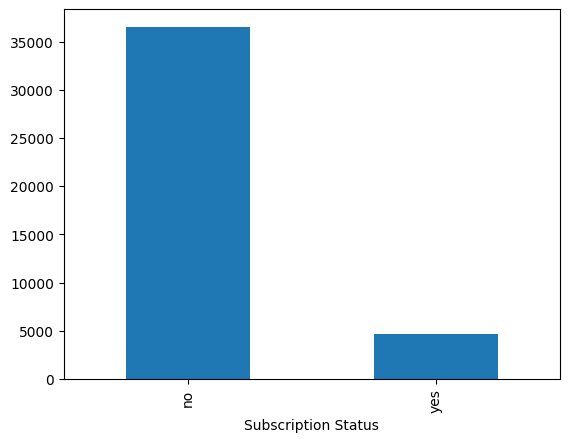

In [98]:
df['Subscription Status'].value_counts().plot(kind='bar')
df['Subscription Status'].value_counts()/df.shape[0]

# purpose is to check for distribution of the target column 

# *** Insights ***
# Dataset is highly imbalanced. ~88.7% not subscribed, only ~ 11.3% subscribed 

# The majority class dominates, which can affect model training & performance hence
# might require class balancing techniques

# Might consider metrics like F1 because it focuses on the minority class (Subscription = Yes) as well
# and provide a more realistic measure of how well the model captures true subscribers.

# Using FI score tells how well the model identifies actual subscribers (Subscription = Yes)

# Accuracy might be misleading (For example, if model predicts "No" for all the data entries --> 88.7% accuracy)

# Data Cleaning

## 1a) "Age" Column fix

In [99]:
# *** "Age" column fix *** 

# Observation 1 --> Data type is "object" 
# Fix done --> Removing the word "years" in all data entries in the "Age" column --> converting to integers

# Observation 2 --> There are age range that are unreasonable (For exmaple: 150 year old)
 

df["Age"] = df["Age"].str.replace(" years", "", regex=False).astype(int)
df.head(5)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27,housemaid,married,high.school,no,None,no,Cell,2,999,no


In [100]:
# Check whether "Age" column is changed to integers
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  int64 
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.8+ MB


In [101]:
age_min = df["Age"].min()
age_max = df["Age"].max()

print("Age range:", age_min, "to", age_max)

Age range: 17 to 150


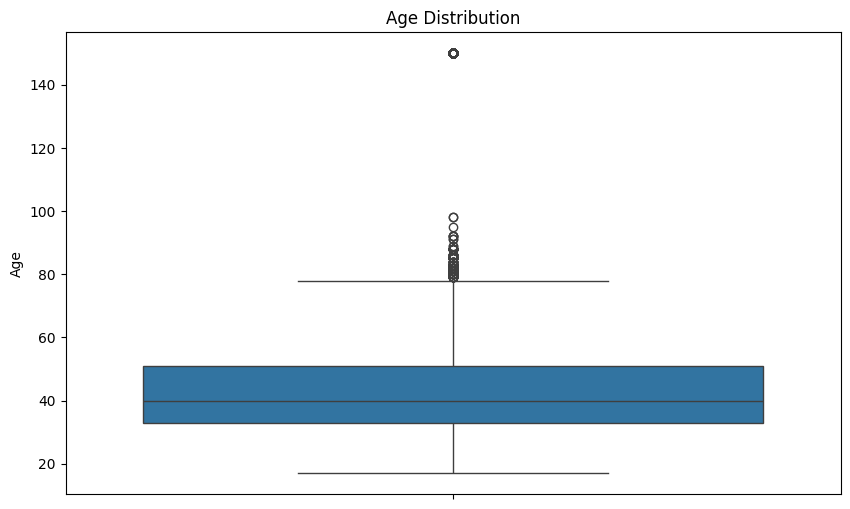

In [102]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Age'])
plt.title('Age Distribution')
plt.ylabel('Age')
plt.show()


# Observation --> There are outliers of age of 150 years old, by considering the average lifespan 
# we seat a reasonable ae range to be from 0 - 100 years 


In [103]:
# Remove Unreasonable age (for example; 150 years old)
df.drop(df[(df["Age"] < 0) | (df["Age"] > 100)].index, inplace=True)
df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 36991 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              36991 non-null  int64 
 1   Age                    36991 non-null  int64 
 2   Occupation             36991 non-null  object
 3   Marital Status         36991 non-null  object
 4   Education Level        36991 non-null  object
 5   Credit Default         36991 non-null  object
 6   Housing Loan           14682 non-null  object
 7   Personal Loan          33253 non-null  object
 8   Contact Method         36991 non-null  object
 9   Campaign Calls         36991 non-null  int64 
 10  Previous Contact Days  36991 non-null  int64 
 11  Subscription Status    36991 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.7+ MB


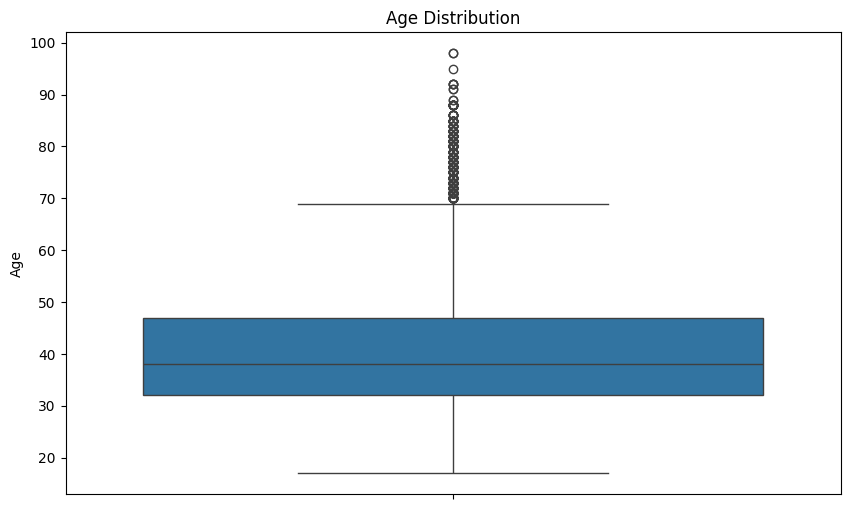

In [104]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Age'])
plt.title('Age Distribution')
plt.ylabel('Age')
plt.show()

## 1b) Cleaning columns with "Unknown"

In [105]:
# df[df.eq("unknown").any(axis=1)]
df.eq("unknown").sum()

Client ID                   0
Age                         0
Occupation                299
Marital Status             71
Education Level          1575
Credit Default           7716
Housing Loan              350
Personal Loan             785
Contact Method              0
Campaign Calls              0
Previous Contact Days       0
Subscription Status         0
dtype: int64

## 1c)Feature Engineering ("Education Level") --> "Number of Years of Education"

In [106]:
# Obervation --> In the "Education Level", the entreis are written in a way including 
# Education Level & some including number of years of studies for some enties such as "basic.9y"

# Hence, we can create another useful column based on the 'Education Level" column, where we can map the "Education Level" column to
# a new column called "Years of Education" which can be useful for futher analysis

edu_map = {
    "illiterate": "0",
    "basic.4y": "4",
    "basic.6y": "6",
    "basic.9y": "9",
    "high.school": "10",
    "professional.course": "13",
    "university.degree": "17",
    "unknown": "0"
}

df["Years of Education"] = df["Education Level"].map(edu_map)
df

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Years of Education
0,32885,57,technician,married,high.school,no,no,yes,Cell,1,999,no,10
1,3170,55,unknown,married,unknown,unknown,yes,no,telephone,2,999,no,0
2,32207,33,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no,9
3,9404,36,admin.,married,high.school,no,no,no,Telephone,4,999,no,10
4,14021,27,housemaid,married,high.school,no,None,no,Cell,2,999,no,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,6266,58,retired,married,professional.course,unknown,no,no,Telephone,2,999,no,13
41184,11285,37,management,married,university.degree,no,no,no,telephone,1,999,no,17
41185,38159,35,admin.,married,high.school,no,None,no,cellular,1,4,yes,10
41186,861,40,management,married,university.degree,no,None,no,telephone,2,999,no,17


In [107]:
df["Education Level"].value_counts()

Education Level
university.degree      10924
high.school             8553
basic.9y                5427
professional.course     4707
basic.4y                3734
basic.6y                2055
unknown                 1575
illiterate                16
Name: count, dtype: int64

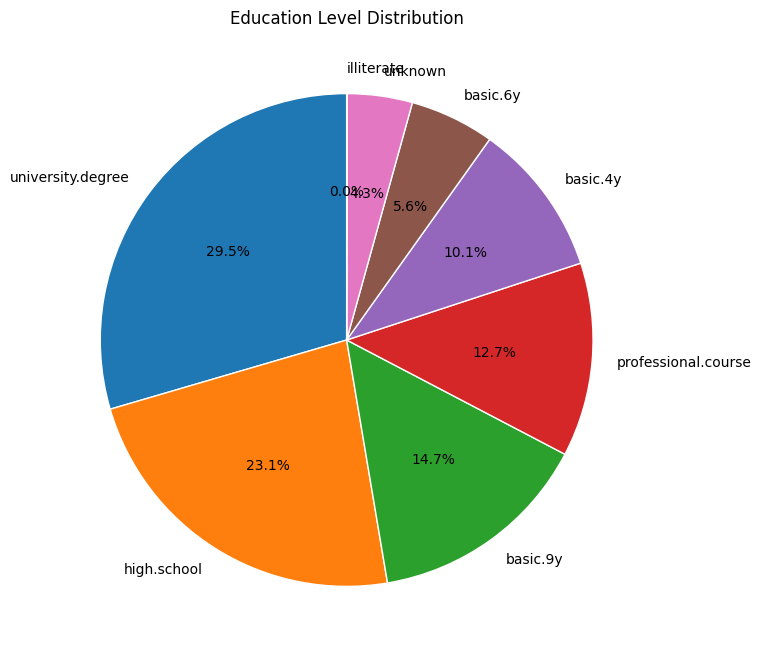

In [108]:
# Standardize education levels by grouping similar categories 
# The original dataset contains granular education levels (basic.4y, basic.6y, 
# professional.course, university.degree, etc.). 
# These categories are too detailed and inconsistent, so we map them into broader 
# (basic.4y/6y/9y) → Basic. This reduces noise and makes analysis easier.

# Count occurrences of each education level
edu_counts = df["Education Level"].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    edu_counts,
    labels=edu_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)

plt.title("Education Level Distribution")
plt.show()


In [109]:
# Mapping dictionary for consolidating education levels
education_map = {
    "illiterate": "illiterate",
    "basic.4y": "Basic",
    "basic.6y": "Basic",
    "basic.9y": "Basic",
    
    "high.school": "High School",
    "professional.course": "Professional Course",
    
    "university.degree": "University Degree",
    
    "unknown": "Unknown"
}

# Apply mapping
df["Education Level"] = df["Education Level"].map(education_map)
df

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,Years of Education
0,32885,57,technician,married,High School,no,no,yes,Cell,1,999,no,10
1,3170,55,unknown,married,Unknown,unknown,yes,no,telephone,2,999,no,0
2,32207,33,blue-collar,married,Basic,no,no,no,cellular,1,999,no,9
3,9404,36,admin.,married,High School,no,no,no,Telephone,4,999,no,10
4,14021,27,housemaid,married,High School,no,None,no,Cell,2,999,no,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,6266,58,retired,married,Professional Course,unknown,no,no,Telephone,2,999,no,13
41184,11285,37,management,married,University Degree,no,no,no,telephone,1,999,no,17
41185,38159,35,admin.,married,High School,no,None,no,cellular,1,4,yes,10
41186,861,40,management,married,University Degree,no,None,no,telephone,2,999,no,17


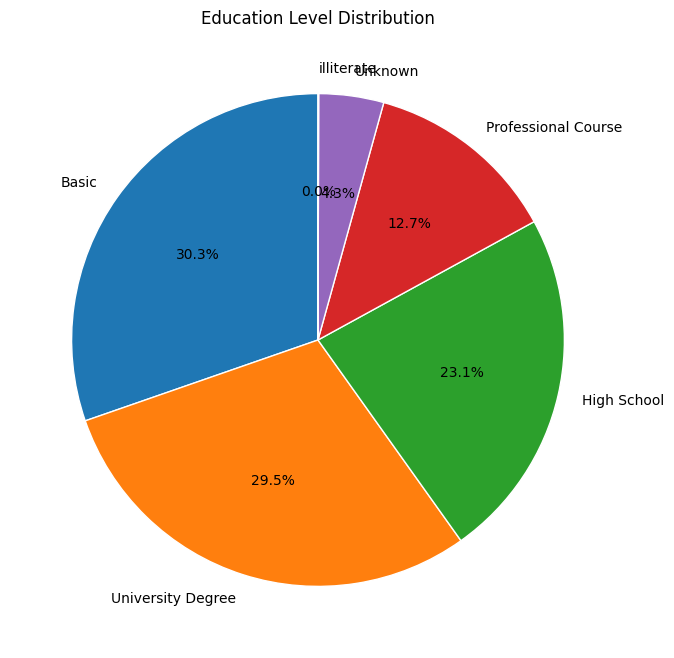

In [111]:
# Count occurrences of each education level after merging the "Basic"
edu_counts = df["Education Level"].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    edu_counts,
    labels=edu_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)

plt.title("Education Level Distribution")
plt.show()

## 1d) Campaign Calls --> Negative Values

In [ ]:
call_min = df["Campaign Calls"].min()
call_max = df["Campaign Calls"].max()

print("Campaign Calls Range:", call_min, "to", call_max)

#Observation --> 

Campaign Calls Range: -41 to 56


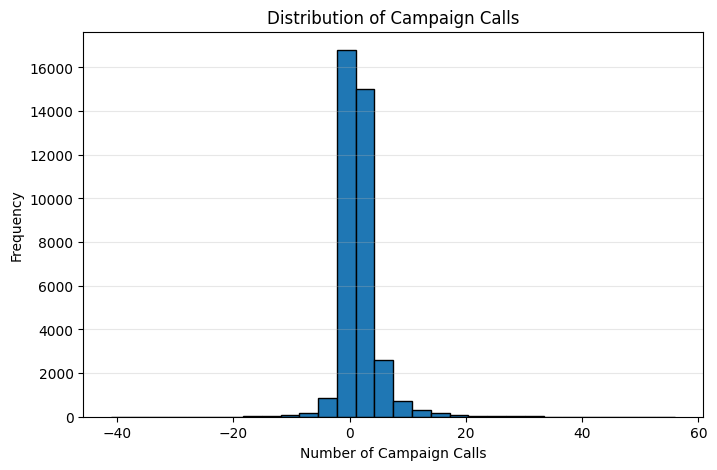

In [112]:
plt.figure(figsize=(8,5))
plt.hist(df["Campaign Calls"], bins=30, edgecolor="black")
plt.title("Distribution of Campaign Calls")
plt.xlabel("Number of Campaign Calls")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)

plt.show()

# 1e) Contact methods 